# Examples

Here are some simple examples of how to run and use the Finite Amplitude Impulse Response (FaIR) model run in the jupyter notebook.

In [1]:
%matplotlib inline

In [2]:
import fair
fair.__version__

'1.5.1+0.gc189bea.dirty'

In [3]:
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)

The "engine" of FaIR is the `fair_scm` function in the `forward` module.

In [4]:
from fair.forward import fair_scm

## CO2 driven run

### Basic example
Here we show how FaIR can be run with step change CO<sub>2</sub> emissions and sinusoidal non-CO<sub>2</sub> forcing timeseries. This is a FaIR v1.0-style setup in which CO<sub>2</sub> is the only emitted species.

In almost every application of FaIR you will probably want to vary the `emissions` time series going in to `fair_scm`. In CO<sub>2</sub>-only mode this is a 1D array of CO<sub>2</sub> emissions. Setting `useMultigas=False` turns off the emissions from non-CO<sub>2</sub> species. To include radiative forcing from non-CO<sub>2</sub> forcers, you can specify a constant or a timeseries to the `other_rf` keyword as in the below example.

The output from FaIR is a 3-tuple of `(C,F,T)` arrays. In CO<sub>2</sub> mode, both `C` (representing CO<sub>2</sub> concentrations in ppm) and `F` (total radiative forcing in W m<sup>-2</sup>) are 1D arrays. `T` (temperature change since the pre-industrial) is always output as a 1D array.

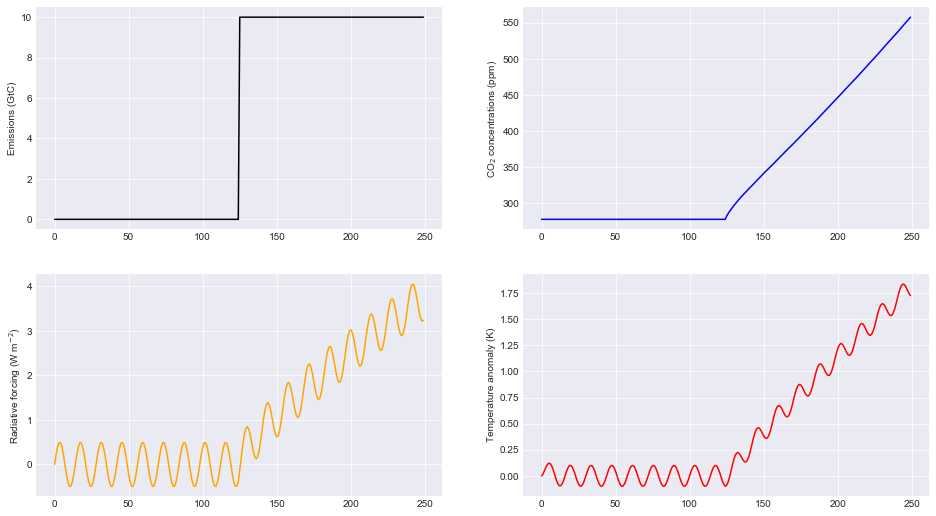

In [5]:
# set up emissions and forcing arrays
emissions = np.zeros(250)   # Unit: GtC
emissions[125:] = 10.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)
    
# run the model
C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0, emissions.size), C, color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F, color='orange')
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T, color='red')
ax4.set_ylabel('Temperature anomaly (K)');

### Forcing-only runs
If you want to specify a pure forcing and bypass the carbon cycle routine this is also possible by setting `emissions=False`. This time, we will add a linear forcing to the sinusodal forcing above. Note that the CO<sub>2</sub> concentrations are not updated from their pre-industrial value.

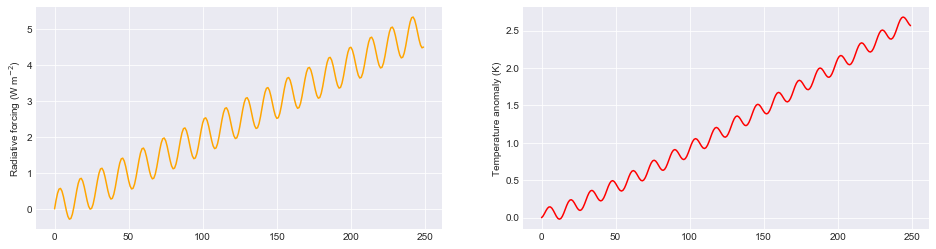

In [6]:
# Define a forcing time series
for x in range(0, emissions.size):
    other_rf[x] = 0.02*x + 0.5 * np.sin(2 * np.pi * (x) / 14.0)
    
# run the model with emissions off
_,F,T = fair.forward.fair_scm(
    emissions=False,
    other_rf=other_rf,
    useMultigas=False
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, other_rf.size), F, color='orange')
ax1.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax1 = fig.add_subplot(222)
ax1.plot(range(0, other_rf.size), T, color='red')
ax1.set_ylabel('Temperature anomaly (K)');

### Varying the carbon cycle parameters
FaIR is set up to simulate the responses to more complex earth system models. This is achieved by a scaling of a four-box decay model for atmospheric carbon dioxide emissions based on the time-integrated airborne fraction of carbon dioxide. This in turn depends on the efficiency of carbon sinks, which is a function of temperature change and total accumulated carbon uptake. Much of the technical detail is described in [Millar et al., (2017)](https://www.atmos-chem-phys.net/17/7213/2017/acp-17-7213-2017.html).

In the carbon cycle, the important variables are `r0`, `rc` and `rt` which are in turn the pre-industrial sensitivity of carbon sinks, the sensitivity to cumulative carbon dioxide emissions, and sensitivity to temperature change.

This time we will demonstrate with a 10 Gt constant pulse and use a 10-member ensemble.

run      r0     rc    rt
  0  37.484 0.0197 3.821
  1  34.309 0.0210 3.755
  2  38.238 0.0173 4.991
  3  42.615 0.0202 3.877
  4  33.829 0.0204 4.714
  5  33.829 0.0131 4.628
  6  42.896 0.0198 3.668
  7  38.837 0.0143 3.736
  8  32.653 0.0237 4.202
  9  37.713 0.0168 4.430


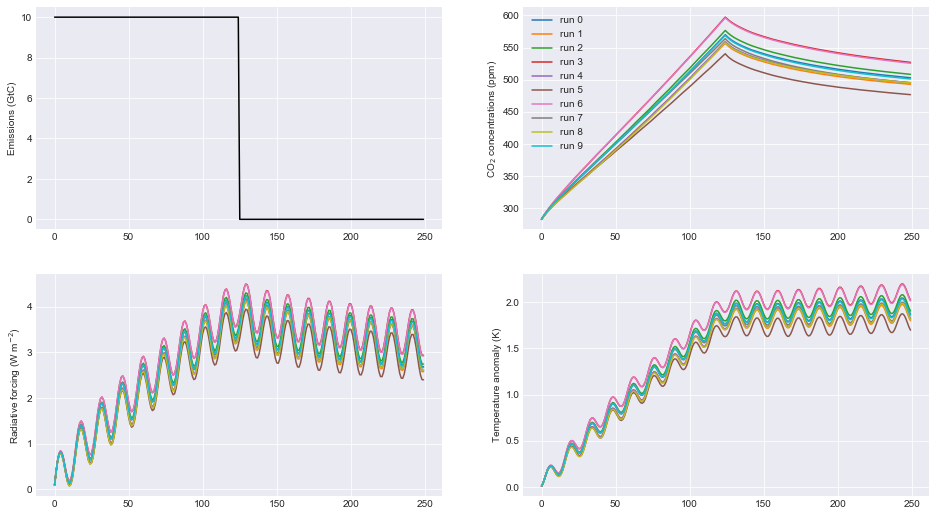

In [7]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays 
nrun = 10
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# Generate some random values of carbon cycle parameters
# use a seed for reproducible results
from scipy.stats import norm
r0 = norm.rvs(size=nrun, loc=35, scale=5.0, random_state=42)
rc = norm.rvs(size=nrun, loc=0.019, scale=0.003, random_state=77)
rt = norm.rvs(size=nrun, loc=4.165, scale=0.5, random_state=1729)

# initialise plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# run the model and plot outputs
print ("run      r0     rc    rt")
for i in range(nrun):
    print ("  %d  %5.3f %5.4f %5.3f" % (i, r0[i], rc[i], rt[i]))
    C[:,i],F[:,i],T[:,i] = fair.forward.fair_scm(
        emissions=emissions,
        other_rf=other_rf,
        useMultigas=False,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    ax2.plot(range(0, emissions.size), C[:,i], label='run %d' % i)
    ax2.set_ylabel('CO$_2$ concentrations (ppm)')
    ax3.plot(range(0, emissions.size), F[:,i])
    ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
    ax4.plot(range(0, emissions.size), T[:,i])
    ax4.set_ylabel('Temperature anomaly (K)');
ax2.legend();

### Changing CO2 lifetime and partitioning coefficients
The CO<sub>2</sub> initial lifetime and partitioning coefficients are quantified by the `tau` and `a` parameters respectively. The rationale follows the four-box model in [Myhre et al. (2013)](https://www.ipcc.ch/pdf/assessment-report/ar5/wg1/supplementary/WG1AR5_Ch08SM_FINAL.pdf), scaled by the impact of land and ocean carbon uptake as described in [Millar et al., (2017)](https://www.atmos-chem-phys.net/17/7213/2017/acp-17-7213-2017.html).

`tau`, in years, is the time constant for each carbon pool and is ordered from slowest carbon pool to fastest, and `a` is the fraction of new CO<sub>2</sub> emissions going in to each pool. The first element of `tau` is usually very large and represents the fraction of CO<sub>2</sub> emissions that remain in the atmosphere "quasi-permanently", i.e. removed only on geological time scales, far past the range of times in which FaIR is expected to give useful results (although nobody will stop you using a smaller value as we demonstrate). An error should be thrown if the sum of `a` is not one.

In the second figure it can be seen that these parameter settings are important for the rate of decay of atmospheric CO<sub>2</sub> in particular.

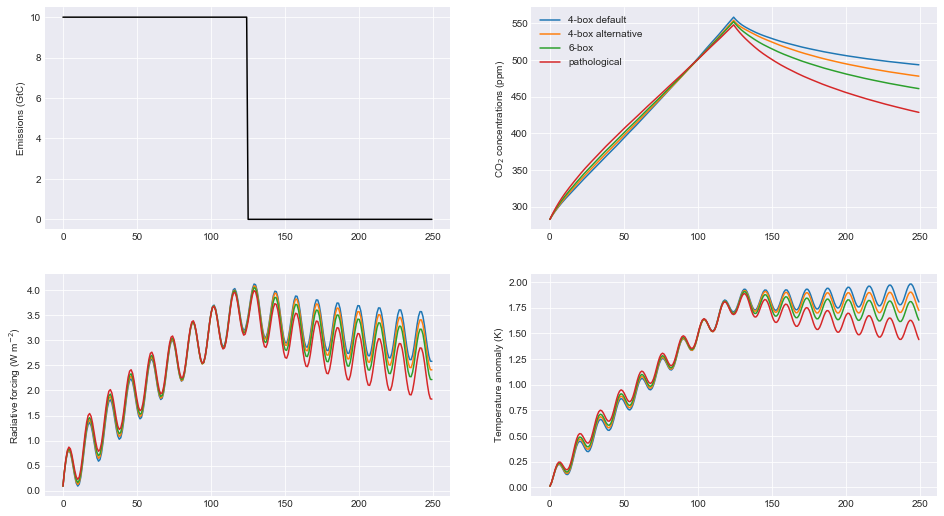

In [8]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays 
nrun=4
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# Play with the carbon boxes
tau2 = np.array([1e6, 400.0, 100.0, 5.0])
a2   = np.ones(4) * 0.25

# Nobody said we had to stick to a four-box model...
tau3 = np.array([1e6, 1000.0, 150.0, 70.0, 15.0, 3.0])
a3   = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])

# A pathological case where tau0 is much smaller than 1e6
# in this example CO2 behaves more like other GHGs
tau4 = np.array([10., 4., 1., 0.3])
a4   = np.ones(4) * 0.25

# run the model for default values
C[:,0],F[:,0],T[:,0] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False)

# ... and for our alternatives
C[:,1],F[:,1],T[:,1] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau2,
    a=a2)
C[:,2],F[:,2],T[:,2] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau3,
    a=a3)
C[:,3],F[:,3],T[:,3] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau4,
    a=a4)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
handles = ax2.plot(range(0, emissions.size), C)
labels = ['4-box default','4-box alternative','6-box','pathological']
ax2.legend(handles, labels)
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F)
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T)
ax4.set_ylabel('Temperature anomaly (K)');

### Time-integrated airborne fraction
The CO<sub>2</sub> time constants, `tau`, are scaled by the 100-year time-integrated airborne fraction for a pulse of CO<sub>2</sub>. This 100-year time horizon can be changed with the keyword `iirf_h`. The actual time-integrated airborne fraction is a function of `r0`, `rt` and `rc`. In high-emissions scenarios this can get quite high, and if it exceeds `iirf_h` (100 years in the default case) we enter a regime in which there is no solution for the scaling factor. Therefore, a maximum IIRF can be set (`iirf_max`, default value 97 years) which places an upper limit on the time-integrated airborne fraction.

In [9]:
# set up emissions and forcing arrays
emissions = np.ones(500) * 10.0   # Unit: GtC
other_rf = 0

# create output arrays 
nrun=3
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# run the model for default values
C[:,0],F[:,0],T[:,0] = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False)

In [10]:
# set iirf time horizon to 60 years. Should get a warning, but it will still let us proceed
C[:,1],F[:,1],T[:,1] = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False,
    iirf_h=60)

/nfs/see-fs-02_users/mencsm/FAIR/fair/forward.py:255: RuntimeWarning: iirf_h=60.000000, which is less than iirf_max (97.000000)
  % (iirf_h, iirf_max), RuntimeWarning)


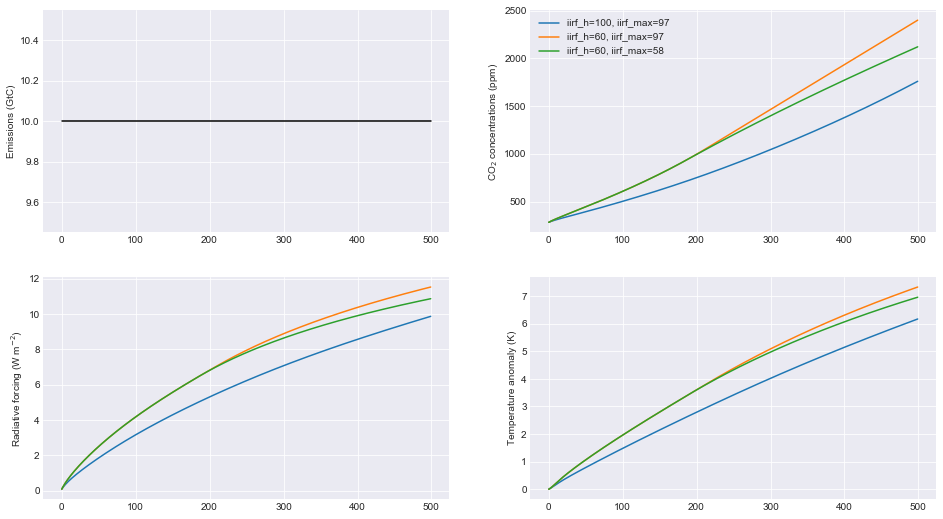

In [11]:
# set maximum iirf
C[:,2],F[:,2],T[:,2] = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False,
    iirf_h=60,
    iirf_max=58)

# plot results
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
handles = ax2.plot(range(0, emissions.size), C)
labels = ['iirf_h=100, iirf_max=97','iirf_h=60, iirf_max=97','iirf_h=60, iirf_max=58']
ax2.legend(handles, labels)
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F)
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T)
ax4.set_ylabel('Temperature anomaly (K)');

### ECS and TCR
The equilibrium climate sensitivity (defined as the equilibrium warming for an abrupt doubling of CO<sub>2</sub> concentrations) and transient climate response (defined as the temperature change after a CO<sub>2</sub> doubling to a 1% per year compound increase in CO<sub>2</sub> concentrations - approximately 70 years) are both key uncertainties in climate science. The temperature response in FaIR depends on both. The `tcrecs` parameter, a 2-element array, controls this.

This next example shows the effect of varying the ECS and TCR. (Note that by definition the case ECS=1.0, TCR=1.75 is not possible, but FaIR can handle such cases anyway).

The biggest effect is on the temperature response, but as the temperature feeds back into the carbon cycle, this also affects the CO<sub>2</sub> concentrations and the radiative forcing.

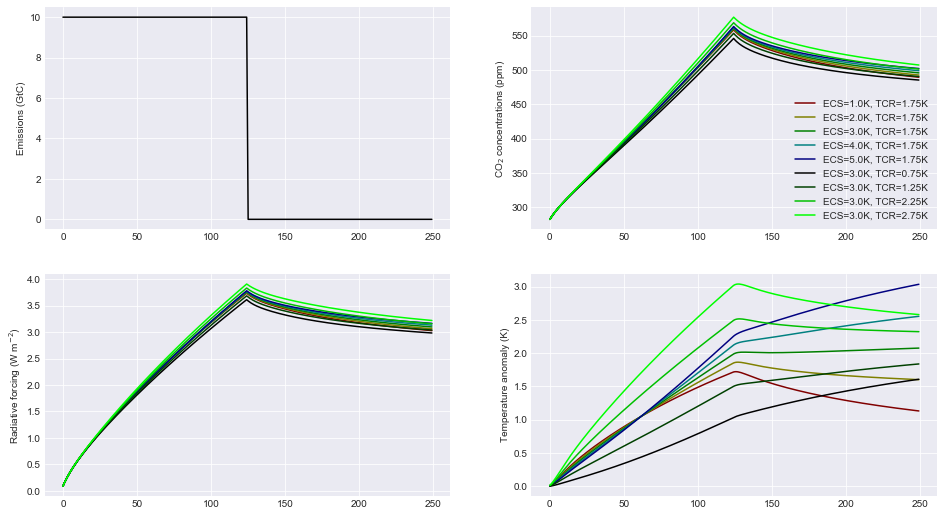

In [12]:
# set up emissions and forcing arrays
emissions = np.zeros(250)
emissions[:125] = 10.0

# create output arrays 
nrun=9
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# initialise plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ecs = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 3.0, 3.0, 3.0, 3.0])
tcr = np.array([1.75, 1.75, 1.75, 1.75, 1.75, 0.75, 1.25, 2.25, 2.75])
colors = ['#800000','#808000','#008000','#008080','#000080', '#000000', '#004000', '#00c000', '#00ff00']

# run the model and plot outputs
for i in range(nrun):
    C[:,i],F[:,i],T[:,i] = fair.forward.fair_scm(
        emissions=emissions,
        useMultigas=False,
        tcrecs=np.array([tcr[i], ecs[i]]),
    )
    
    ax2.plot(range(0, emissions.size), C[:,i], color=colors[i], label='ECS=%3.1fK, TCR=%4.2fK' % (ecs[i], tcr[i]))
    ax2.set_ylabel('CO$_2$ concentrations (ppm)')
    ax3.plot(range(0, emissions.size), F[:,i], color=colors[i])
    ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
    ax4.plot(range(0, emissions.size), T[:,i], color=colors[i])
    ax4.set_ylabel('Temperature anomaly (K)');
ax2.legend();

Some recent studies ([Armour 2017](https://www.nature.com/articles/nclimate3278); [Gregory and Andrews 2016](http://onlinelibrary.wiley.com/doi/10.1002/2016GL068406/abstract)) suggest that ECS and TCR may not be constant. Fortunately we can investigate this in FaIR by specifying `tcrecs` as a two dimensional `(nt, 2)` array. Notice the effect that a varying ECS/TCR has on the temperature.

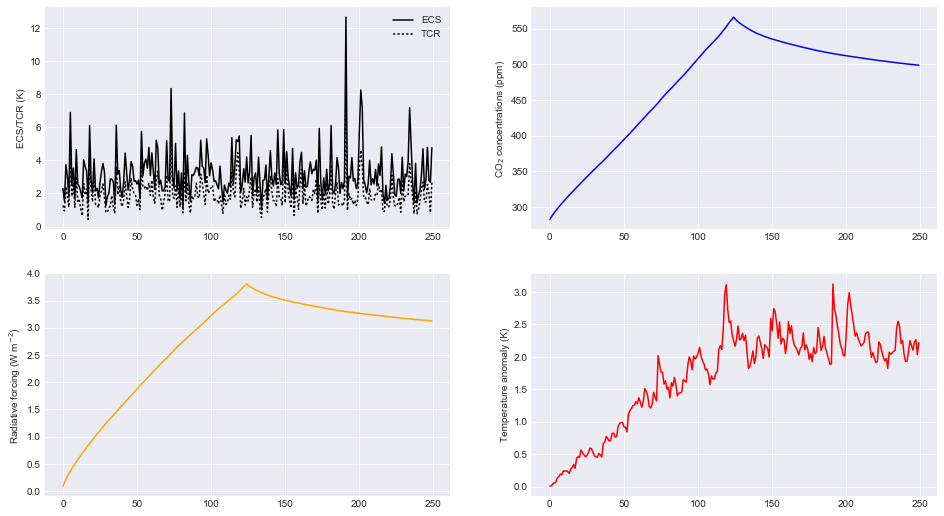

In [13]:
from scipy.stats import lognorm, truncnorm

# generate an ECS time series that roughly follows the AR5 likely range
ecs = lognorm.rvs(0.4, size=250, scale=3, random_state=299)

# define TCR in terms of a realised warming fraction
rwf = truncnorm.rvs(-3, 3, loc=0.6, scale=0.1, size=250, random_state=301)
tcr = rwf*ecs

emissions = np.zeros(250)
emissions[:125] = 10.0

C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False,
    tcrecs=np.vstack([tcr, ecs]).T,
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), ecs, color='black', label='ECS')
ax1.plot(range(0, emissions.size), tcr, color='black', ls=':', label='TCR')
ax1.legend()
ax1.set_ylabel('ECS/TCR (K)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0, emissions.size), C, color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F, color='orange')
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T, color='red')
ax4.set_ylabel('Temperature anomaly (K)');

The alternative is to specify the values of `q` directly (a 2D array) that go into the temperature calculation, bypassing `tcrecs` completely (setting `tcrecs=None`). It is not known under what circumstances the user may want to do this, but be assured it's possible!

In [14]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0
emissions[125:] = 0.0

q = np.ones((250,2))
q[:,0] = 0.2
q[:,1] = 0.6
C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False,
    tcrecs=None,
    q=q,
)
print (C[-1], F[-1], T[-1])

500.552434905 3.14769875538 2.27905105488


### Temperature time constants

The slow and fast response of global mean surface temperature is governed by the two-element array `d`: this parameter determines the rate at which radiative forcing is "realised" as a change in surface temperature.

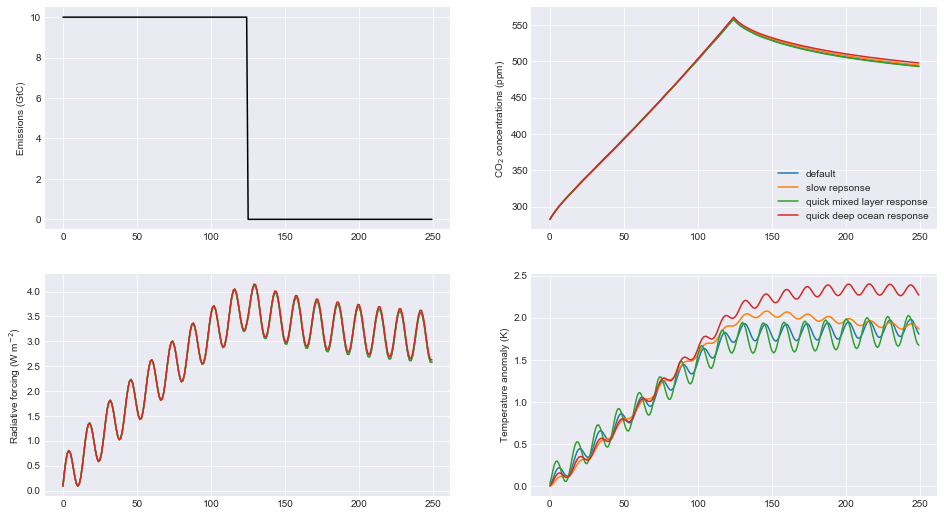

In [15]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays 
nrun=4
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# run the model for default values
C[:,0],F[:,0],T[:,0] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False)

# ... and for our alternatives
C[:,1],F[:,1],T[:,1] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    d=np.array([1000.0, 18.0]))
C[:,2],F[:,2],T[:,2] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    d=np.array([239.0, 1.0]))
C[:,3],F[:,3],T[:,3] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    d=np.array([60., 4.1]))

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
handles = ax2.plot(range(0, emissions.size), C)
labels = ['default','slow repsonse','quick mixed layer response','quick deep ocean response']
ax2.legend(handles, labels)
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F)
ax3.set_ylabel('Radiative forcing (W m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T)
ax4.set_ylabel('Temperature anomaly (K)');

## Multi-species mode

More interesting scenarios can be created with the full suite of forcing agents. The key changes from CO<sub>2</sub>-only mode that should be remembered are:

* This time the emissions dataset is a (nt, 40) array of inputs
* `useMultigas` should be set to `True`, or omitted (this is the default option)
* The concentration and forcing outputs are themselves 2-dimensional arrays of size (nt, 31) and (nt, 13) respectively
* More input options to `fair_scm` become available.

The basic call to fair_scm remains the same:

```
(C,F,T) = fair_scm(emissions=emissions, **kwargs)
```

### Emissions
In multi-species model, emissions are input as an `(nt, 40)` emissions array. The index order and units of the columns are as follows:

 Index     | Species        | Units                                          
-----------|----------------|------
 0         | Year           | year 
 1         | CO<sub>2</sub>-fossil  | GtC/yr                                               
 2         | CO<sub>2</sub>-landuse | GtC/yr                                               
 3         | CH<sub>4</sub>         | Mt/yr 
 4         | N<sub>2</sub>O         | MtN<sub>2</sub>/yr 
 5         | SOx            | MtS/yr 
 6         | CO             | Mt/yr 
 7         | NMVOC          | Mt/yr 
 8         | NOx            | MtN/yr 
 9         | BC             | Mt/yr 
 10        | OC             | Mt/yr 
 11        | NH<sub>3</sub>         | Mt/yr 
 12        | CF<sub>4</sub>         | kt/yr 
 13        | C<sub>2</sub>F<sub>6</sub>     | kt/yr   
 14        | C<sub>6</sub>F<sub>14</sub>  | kt/yr   
 15        | HFC23          | kt/yr   
 16        | HFC32          | kt/yr   
 17        | HFC43-10       | kt/yr   
 18        | HFC125         | kt/yr   
 19        | HFC134a        | kt/yr   
 20        | HFC143a        | kt/yr   
 21        | HFC227ea       | kt/yr  
 22        | HFC245fa       | kt/yr   
 23        | SF<sub>6</sub>         | kt/yr   
 24        | CFC11          | kt/yr   
 25        | CFC12          | kt/yr   
 26        | CFC113         | kt/yr   
 27        | CFC114         | kt/yr   
 28        | CFC115         | kt/yr   
 29        | CCl<sub>4</sub>        | kt/yr   
 30        | Methyl chloroform | kt/yr   
 31        | HCFC22         | kt/yr    
 32        | HCFC141b       | kt/yr    
 33        | HCFC142b       | kt/yr   
 34        | Halon 1211     | kt/yr   
 35        | Halon 1202     | kt/yr   
 36        | Halon 1301     | kt/yr   
 37        | Halon 2401     | kt/yr   
 38        | CH<sub>3</sub>Br       | kt/yr 
 39        | CH<sub>3</sub>Cl       | kt/yr  

The index order of the columns follows that of the RCP datasets at http://www.pik-potsdam.de/~mmalte/rcps/.

### GHG Concentrations
Multi-species FaIR tracks the atmospheric concentrations of 31 GHG species; `C` is returned as a `(nt, 31)` array. The colums are indexed as follows:

 Index     | Species                     | Units                                          
-----------|-----------------------------|------ 
 0         | CO<sub>2</sub>              | ppm                                              
 1         | CH<sub>4</sub>              | ppb     
 2         | N<sub>2</sub>O              | ppb    
 3         | CF<sub>4</sub>              | ppt    
 4         | C<sub>2</sub>F<sub>6</sub>  | ppt    
 5         | C<sub>6</sub>F<sub>14</sub> | ppt    
 6         | HFC23          | ppt   
 7         | HFC32          | ppt   
 8         | HFC43-10       | ppt  
 9         | HFC125         | ppt   
 10        | HFC134a        | ppt   
 11        | HFC143a        | ppt  
 12        | HFC227ea       | ppt 
 13        | HFC245fa       | ppt   
 14        | SF<sub>6</sub>         | ppt   
 15        | CFC11          | ppt   
 16        | CFC12          | ppt   
 17        | CFC113         | ppt  
 18        | CFC114         | ppt   
 19        | CFC115         | ppt   
 20        | CCl<sub>4</sub>        | ppt  
 21        | Methyl chloroform | ppt   
 22        | HCFC22         | ppt   
 23        | HCFC141b       | ppt    
 24        | HCFC142b       | ppt  
 25        | Halon 1211     | ppt   
 26        | Halon 1202     | ppt   
 27        | Halon 1301     | ppt   
 28        | Halon 2401     | ppt  
 29        | CH<sub>3</sub>Br       | ppt 
 30        | CH<sub>3</sub>Cl       | ppt  


### Effective radiative forcing
Finally, a `(nt, 13)` array `F` of effective radiative forcing is returned (all units W m<sup>-2</sup>):
 
 Index     | Species                                               
-----------|-----------
 0         | CO<sub>2</sub>                                             
 1         | CH<sub>4</sub>  
 2         | N<sub>2</sub>O  
 3         | All other well-mixed GHGs 
 4         | Tropospheric O<sub>3</sub>   
 5         | Stratospheric O<sub>3</sub>    
 6         | Stratospheric water vapour from CH<sub>4</sub> oxidation   
 7         | Contrails  
 8         | Aerosols    
 9         | Black carbon on snow  
 10        | Land use change   
 11        | Volcanic 
 12        | Solar 

With the exception of volcanic and solar, all forcing outputs are calculated from the input emissions.

## A multi-gas example

This sets up a multi-gas emissions array and serves to demonstrate some of the options that can be specified in `fair_scm` for multi-gas runs (most are changed from the default and some are non-sensical but shown for illustration). Note this is a completely hypothetical scenario!

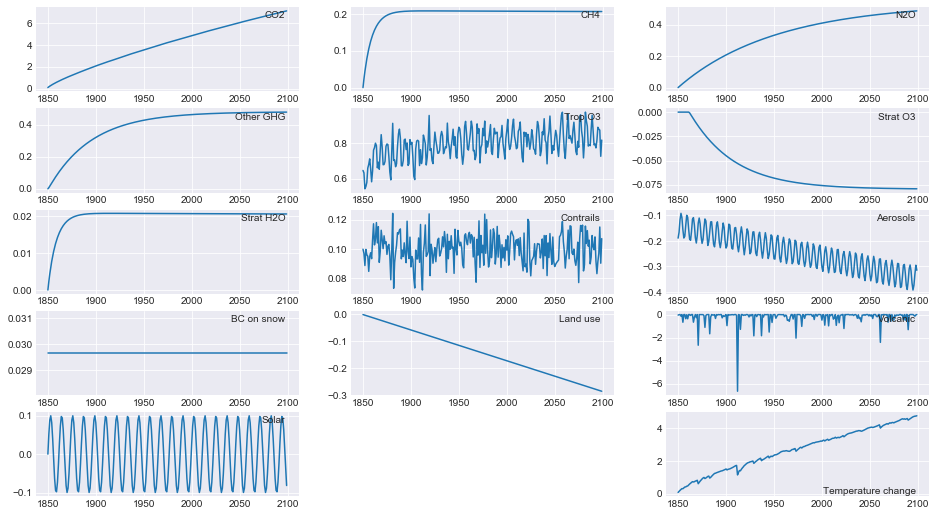

In [16]:
from scipy.stats import gamma
emissions = np.zeros((250,40))

# remember column zero is the years
emissions[:,0] = np.arange(1850,2100)

# add some CO2 fossil and land use, GtC/yr
emissions[:,1] = 10.
emissions[:,2] = 1.

# some methane and nitrous oxide in this example, Mt/yr
emissions[:,3] = 300.
emissions[:,4] = 19.

# aerosol and ozone precursors, Mt/yr
emissions[:,5] = 0.1*np.arange(250)   # SOx
emissions[:,6] = 500.*np.log(1+np.arange(250))  # CO
emissions[:,7] = 100.+100.*np.cos(np.arange(250))  # NMVOC
emissions[:,8] = 40.*norm.rvs(loc=1, scale=0.1, size=250, random_state=9)   # NOx
emissions[:,9] = 6.    # BC
emissions[:,10] = 30.  # OC
emissions[:,11] = 35.  # NH3

# throw in some CFCs
emissions[:,24] = 1000. # CFC11
# and leave all other emissions as zero.

# Volcanic and solar forcing are provided externally. Let's invent some
solar = 0.1 * np.sin(2 * np.pi * np.arange(250) / 11.5)
volcanic = -gamma.rvs(0.2, size=250, random_state=100)

# efficacies are the temperature change for each forcing agent compared to CO2
# in our runs we usually set the efficacy of BC on snow to 3, following Bond et
# al (2013)
eff = np.ones(13)
eff[9] = 3.0

# b_aero: ERFari for each SLCF species (indices 5 to 11)
# b_tro3: tropospheric ozone coeffs for CH4, CO, NMVOC, NOx
C,F,T = fair_scm(emissions=emissions,
                 natural=np.zeros((250,2)), # natural emissions of CH4 and N2O
                 aviNOx_frac=0.05, # proportion of NOx emissions from aviation
                 fossilCH4_frac=0.25, # proportion of anthro CH4 emis from fossil fuels
                 oxCH4_frac=0.61, # proportion of fossil CH4 eventually oxidised to CO2
                 stwv_from_ch4=0.1, # proportion of CH4 ERF contributing to strat H2O
                 ghg_forcing='Etminan',  # etminan or myhre
                 useStevenson=False, # Stevenson or regression based trop. O3 forcing?
                 b_aero = np.array([-35,0,-5,-6,450,-40,-10])*1e-4,
                 b_tro3 = np.array([3., 1., 8., 99.])*1e-4,
                 aerosol_forcing = 'aerocom+ghan',  # aerocom, aerocom+ghan or stevens
                 F_solar = solar,
                 F_volcanic = volcanic,
                 efficacy = eff
                )

# Plot the forcing from each component
fig = plt.figure()
label = ['CO2','CH4','N2O','Other GHG','Trop O3','Strat O3','Strat H2O','Contrails','Aerosols',
         'BC on snow', 'Land use', 'Volcanic', 'Solar']
for i in range(13):
    ax = fig.add_subplot(5,3,i+1)
    ax.plot(np.arange(1850,2100), F[:,i])
    ax.text(0.95,0.95,label[i],transform=ax.transAxes,va='top', ha='right')
# plot temperature change
ax = fig.add_subplot(5,3,15)
ax.plot(np.arange(1850,2100),T)
ax.text(0.95, 0, 'Temperature change', transform=ax.transAxes, va='bottom', ha='right')

## RCP scenarios

Creating a 40-column emissions input table may seem a lot of work. FaIR comes with tools to make your life easier!

We can run FaIR with the CO<sub>2</sub> emissions and non-CO<sub>2</sub> forcing from the four representative concentration pathway scenarios. These can be imported from the `RCPs` module and have inbuilt `Forcing` and `Emissions` classes. There is also a tool for converting MAGICC6 \*.SCEN files into FaIR input (in `fair/tools/magicc`).

Here we show the FaIR implementation of the RCP scenarios.

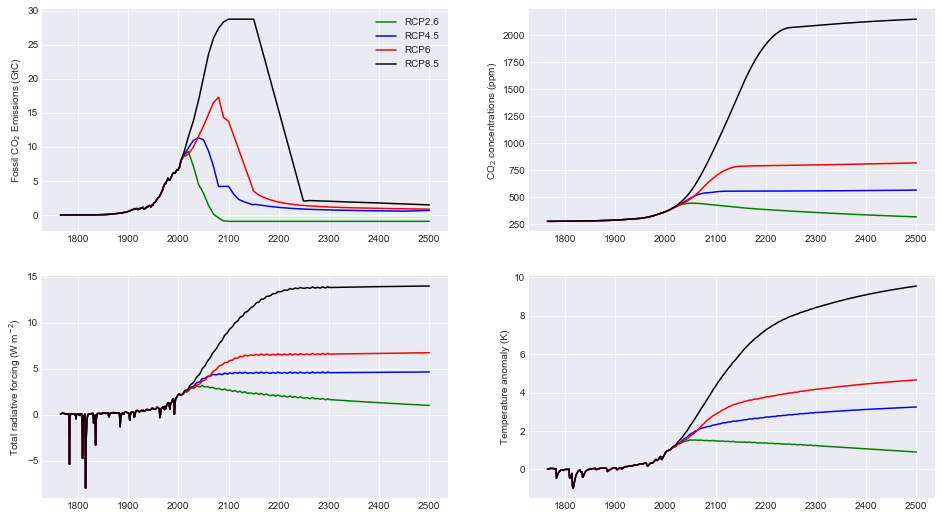

In [17]:
# Get RCP modules
from fair.RCPs import rcp26, rcp45, rcp60, rcp85

# Basic RCP runs
C26, F26, T26 = fair.forward.fair_scm(emissions=rcp26.Emissions.emissions)
C45, F45, T45 = fair.forward.fair_scm(emissions=rcp45.Emissions.emissions)
C60, F60, T60 = fair.forward.fair_scm(emissions=rcp60.Emissions.emissions)
C85, F85, T85 = fair.forward.fair_scm(emissions=rcp85.Emissions.emissions)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(rcp26.Emissions.year, rcp26.Emissions.co2_fossil, color='green', label='RCP2.6')
# just show CO2 conc.
ax2.plot(rcp26.Emissions.year, C26[:, 0], color='green')
# sum over axis 1 to get total ERF
ax3.plot(rcp26.Emissions.year, np.sum(F26, axis=1), color='green')
ax4.plot(rcp26.Emissions.year, T26, color='green')

ax1.plot(rcp45.Emissions.year, rcp45.Emissions.co2_fossil, color='blue', label='RCP4.5')
ax2.plot(rcp45.Emissions.year, C45[:, 0], color='blue')
ax3.plot(rcp45.Emissions.year, np.sum(F45, axis=1), color='blue')
ax4.plot(rcp45.Emissions.year, T45, color='blue')

ax1.plot(rcp60.Emissions.year, rcp60.Emissions.co2_fossil, color='red', label='RCP6')
ax2.plot(rcp60.Emissions.year, C60[:, 0], color='red')
ax3.plot(rcp60.Emissions.year, np.sum(F60, axis=1), color='red')
ax4.plot(rcp60.Emissions.year, T60, color='red')

ax1.plot(rcp85.Emissions.year, rcp85.Emissions.co2_fossil, color='black', label='RCP8.5')
ax2.plot(rcp85.Emissions.year, C85[:, 0], color='black')
ax3.plot(rcp85.Emissions.year, np.sum(F85, axis=1), color='black')
ax4.plot(rcp85.Emissions.year, T85, color='black')

ax1.set_ylabel('Fossil CO$_2$ Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Total radiative forcing (W m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)');

## Concentrations of well-mixed greenhouse gases

In this example we also show how to group minor gases into CFC12 and HFC134a equivalent concentrations. Refer to table above for gas indices.

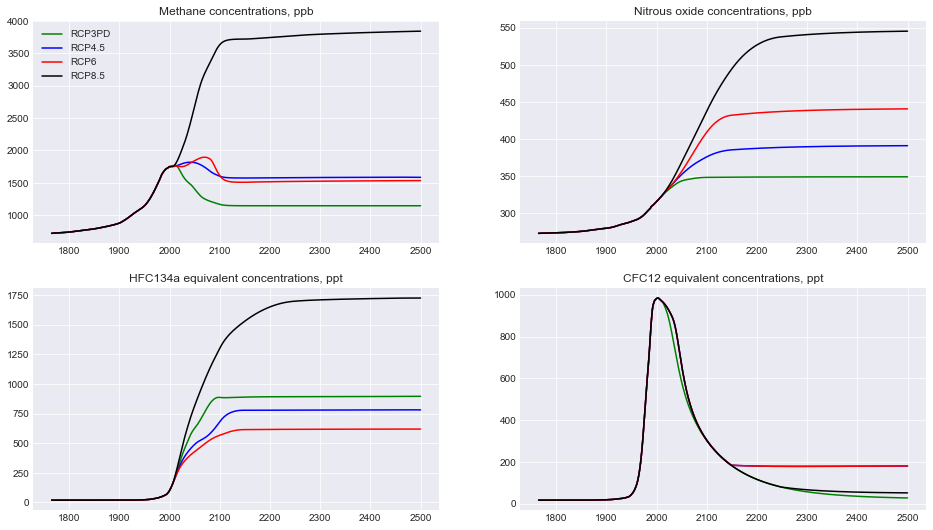

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(rcp26.Emissions.year, C26[:,1], color='green', label='RCP3PD')
ax1.plot(rcp45.Emissions.year, C45[:,1], color='blue', label='RCP4.5')
ax1.plot(rcp60.Emissions.year, C60[:,1], color='red', label='RCP6')
ax1.plot(rcp85.Emissions.year, C85[:,1], color='black', label='RCP8.5')
ax1.set_title("Methane concentrations, ppb")

ax2.plot(rcp26.Emissions.year, C26[:,2], color='green', label='RCP3PD')
ax2.plot(rcp45.Emissions.year, C45[:,2], color='blue', label='RCP4.5')
ax2.plot(rcp60.Emissions.year, C60[:,2], color='red', label='RCP6')
ax2.plot(rcp85.Emissions.year, C85[:,2], color='black', label='RCP8.5')
ax2.set_title("Nitrous oxide concentrations, ppb")

# Weight H and F gases by radiative efficiency
from fair.constants import radeff

# indices 3:15 are HFCs and PFCs
C26_hfc134a_eq = np.sum(C26[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A   
C45_hfc134a_eq = np.sum(C45[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A
C60_hfc134a_eq = np.sum(C60[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A
C85_hfc134a_eq = np.sum(C85[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A

# indices 15:31 are ozone depleters
C26_cfc12_eq = np.sum(C26[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12  
C45_cfc12_eq = np.sum(C45[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12
C60_cfc12_eq = np.sum(C60[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12
C85_cfc12_eq = np.sum(C85[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12

ax3.plot(rcp26.Emissions.year, C26_hfc134a_eq, color='green', label='RCP2.6')
ax3.plot(rcp45.Emissions.year, C45_hfc134a_eq, color='blue', label='RCP4.5')
ax3.plot(rcp60.Emissions.year, C60_hfc134a_eq, color='red', label='RCP6')
ax3.plot(rcp85.Emissions.year, C85_hfc134a_eq, color='black', label='RCP8.5')
ax3.set_title("HFC134a equivalent concentrations, ppt")

ax4.plot(rcp26.Emissions.year, C26_cfc12_eq, color='green', label='RCP2.6')
ax4.plot(rcp45.Emissions.year, C45_cfc12_eq, color='blue', label='RCP4.5')
ax4.plot(rcp60.Emissions.year, C60_cfc12_eq, color='red', label='RCP6')
ax4.plot(rcp85.Emissions.year, C85_cfc12_eq, color='black', label='RCP8.5')
ax4.set_title("CFC12 equivalent concentrations, ppt")
ax1.legend();

## Radiative forcing
Here we show some of the more interesting examples for the effective radiative forcing time series coming out of FaIR.

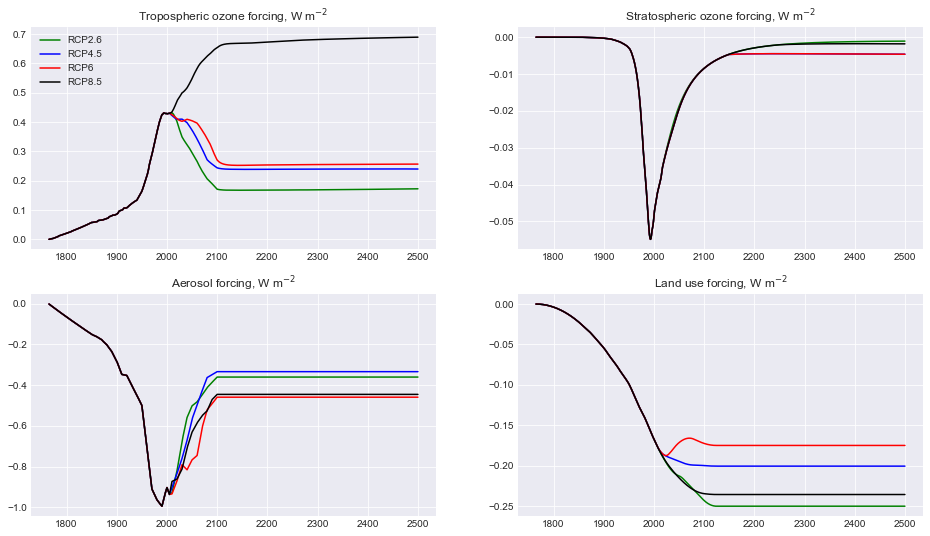

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(rcp26.Emissions.year, F26[:,4], color='green', label='RCP2.6')
ax1.plot(rcp45.Emissions.year, F45[:,4], color='blue', label='RCP4.5')
ax1.plot(rcp60.Emissions.year, F60[:,4], color='red', label='RCP6')
ax1.plot(rcp85.Emissions.year, F85[:,4], color='black', label='RCP8.5')
ax1.set_title("Tropospheric ozone forcing, W m$^{-2}$")

ax2.plot(rcp26.Emissions.year, F26[:,5], color='green', label='RCP2.6')
ax2.plot(rcp45.Emissions.year, F45[:,5], color='blue', label='RCP4.5')
ax2.plot(rcp60.Emissions.year, F60[:,5], color='red', label='RCP6')
ax2.plot(rcp85.Emissions.year, F85[:,5], color='black', label='RCP8.5')
ax2.set_title("Stratospheric ozone forcing, W m$^{-2}$")

ax3.plot(rcp26.Emissions.year, F26[:,8], color='green', label='RCP2.6')
ax3.plot(rcp45.Emissions.year, F45[:,8], color='blue', label='RCP4.5')
ax3.plot(rcp60.Emissions.year, F60[:,8], color='red', label='RCP6')
ax3.plot(rcp85.Emissions.year, F85[:,8], color='black', label='RCP8.5')
ax3.set_title("Aerosol forcing, W m$^{-2}$")

ax4.plot(rcp26.Emissions.year, F26[:,10], color='green', label='RCP2.6')
ax4.plot(rcp45.Emissions.year, F45[:,10], color='blue', label='RCP4.5')
ax4.plot(rcp60.Emissions.year, F60[:,10], color='red', label='RCP6')
ax4.plot(rcp85.Emissions.year, F85[:,10], color='black', label='RCP8.5')
ax4.set_title("Land use forcing, W m$^{-2}$")
ax1.legend();

## Running in concentration-driven mode

It is possible to drive FaIR with concentrations rather than emissions. Set the `emissions_driven` keyword to `False` and specify the concentrations with `C`. The function still returns the `C, F, T` tuple; comparison of the input concentrations with the output concentrations can be performed as a sense check to verify the code is not changing anything.

### CO2 only

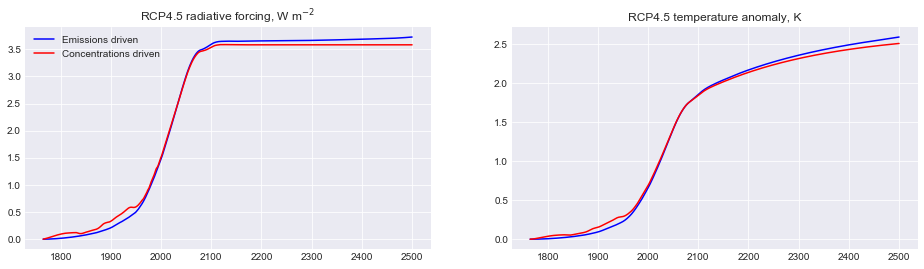

In [20]:
# Produce a base emissions-driven RCP4.5 run
C1,F1,T1 = fair.forward.fair_scm(
    emissions_driven=True,
    emissions=fair.RCPs.rcp45.Emissions.co2,
    useMultigas=False)

# Produce a concentration driven RCP4.5 run
C2,F2,T2 = fair.forward.fair_scm(
    emissions_driven=False,
    C=fair.RCPs.rcp45.Concentrations.co2,
    useMultigas=False)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(rcp45.Emissions.year, F1, color='blue', label='Emissions driven')
ax1.plot(rcp45.Emissions.year, F2, color='red', label='Concentrations driven')
ax1.set_title("RCP4.5 radiative forcing, W m$^{-2}$")

ax2.plot(rcp45.Emissions.year, T1, color='blue', label='Emissions driven')
ax2.plot(rcp45.Emissions.year, T2, color='red', label='Concentrations driven')
ax2.set_title("RCP4.5 temperature anomaly, K")
ax1.legend();

### Diagnosing CO2 emissions

For carbon budget calculations it is often useful to calculate (cumulative) CO2 emissions for a given concentration of CO2. The `fair.inverse` module provides the opportunity to do this. Currently `fair.inverse` only runs in CO2 mode.

In [21]:
from fair.inverse import inverse_fair_scm

Many of the options are the same as for the `forward` model, and provide reasonable sensible defaults if not specified. The classic example of a 1% per year CO2 increase will be demonstrated.

In [22]:
nt = 140 # years
C  = 278. * 1.01**np.arange(nt) # compound 1% increase in CO2 concentrations

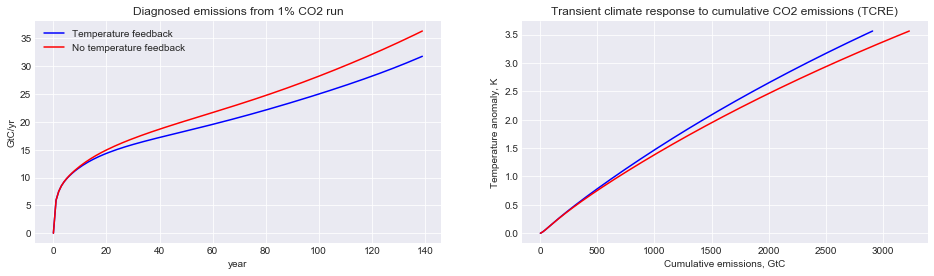

In [23]:
# run with default carbon cycle parameters
E1, F1, T1 = inverse_fair_scm(C=C)

# show the effect of turning off the temperature feedback
E2, F2, T2 = inverse_fair_scm(C=C, rt=0)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(nt), E1, color='blue', label='Temperature feedback')
ax1.plot(range(nt), E2, color='red', label='No temperature feedback')
ax1.set_title("Diagnosed emissions from 1% CO2 run")
ax1.set_xlabel('year')
ax1.set_ylabel('GtC/yr')
ax2.plot(np.cumsum(E1), T1, color='blue')
ax2.plot(np.cumsum(E2), T1, color='red')
ax2.set_title("Transient climate response to cumulative CO2 emissions (TCRE)")
ax2.set_xlabel("Cumulative emissions, GtC")
ax2.set_ylabel("Temperature anomaly, K")
ax1.legend();

### Multi-gas

In multi-gas concentrations driven mode, all non-WMGHG forcing that is normally calculated from emissions (tropospheric ozone, aviation contrails, aerosols, black carbon on snow and land use) is provided externally. The default values for each are zero. WMGHG forcing that is calculated from concentrations or forcing (stratospheric ozone and stratospheric water vapour from methane) is not affected.

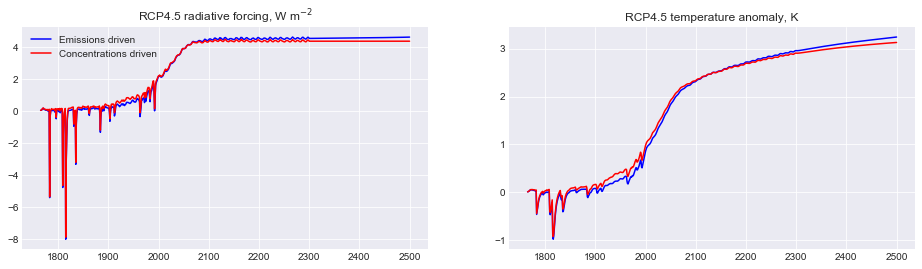

In [24]:
# Produce a base emissions-driven RCP4.5 run
C1,F1,T1 = fair.forward.fair_scm(
    emissions_driven=True,
    emissions=fair.RCPs.rcp45.Emissions.emissions,
    useMultigas=True)

# Produce a concentration driven RCP4.5 run
# use Meinshausen's external forcing here
C2,F2,T2 = fair.forward.fair_scm(
    emissions_driven=False,
    C=fair.RCPs.rcp45.Concentrations.gases,
    F_tropO3 = rcp45.Forcing.tropo3,
    F_aerosol = rcp45.Forcing.aero+rcp45.Forcing.cloud,
    F_bcsnow = rcp45.Forcing.bcsnow,
    useMultigas=True)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(rcp45.Emissions.year, np.sum(F1,axis=1), color='blue', label='Emissions driven')
ax1.plot(rcp45.Emissions.year, np.sum(F2,axis=1), color='red', label='Concentrations driven')
ax1.set_title("RCP4.5 radiative forcing, W m$^{-2}$")

ax2.plot(rcp45.Emissions.year, T1, color='blue', label='Emissions driven')
ax2.plot(rcp45.Emissions.year, T2, color='red', label='Concentrations driven')
ax2.set_title("RCP4.5 temperature anomaly, K")
ax1.legend();

## Natural emissions and GHG lifetimes

In order to balance historical concentrations of methane and nitrous oxide, we assume a time-varying profile of natural emissions. This can be varied with the `natural` keyword (a `(nt, 2)` array of methane and nitrous oxide emissions). Additionally, the default greenhouse gas decay constants can be modified with the `lifetimes` keyword (shape `(31,)`).

It can clearly be seen that natural emissions are important in maintaining historical concentrations.

9.3 121.0


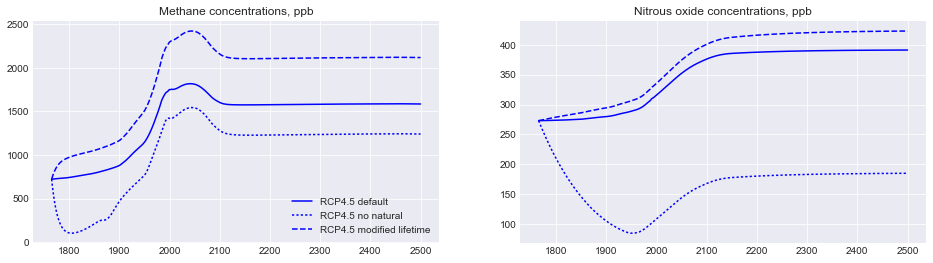

In [25]:
# Change default lifetimes of CH4 and N2O
from fair.constants import lifetime
lt = lifetime.aslist
lt[1] = 12.6
lt[2] = 131.

# what are the defaults?
print (lifetime.CH4, lifetime.N2O)

# How long are the RCPs?
nt = len(rcp45.Emissions.year)

# Run FaIR under RCP4.5 with no natural emissions
C1,F1,T1 = fair_scm(emissions=rcp45.Emissions.emissions,
                    natural=np.zeros((nt,2))
                    )

# Run FaIR under RCP4.5 with modified lifetimes
C2,F2,T2 = fair_scm(emissions=rcp45.Emissions.emissions,
                    lifetimes=lt
                    )

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(rcp45.Emissions.year, C45[:,1], color='blue', label='RCP4.5 default')
ax1.plot(rcp45.Emissions.year, C1[:,1], color='blue', ls=':', label='RCP4.5 no natural')
ax1.plot(rcp45.Emissions.year, C2[:,1], color='blue', ls='--', label='RCP4.5 modified lifetime')
ax1.set_title("Methane concentrations, ppb")
ax2.plot(rcp45.Emissions.year, C45[:,2], color='blue', label='RCP4.5')
ax2.plot(rcp45.Emissions.year, C1[:,2], color='blue', ls=':', label='RCP4.5 no natural')
ax2.plot(rcp45.Emissions.year, C2[:,2], color='blue', ls='--', label='RCP4.5 modified lifetime')
ax2.set_title("Nitrous oxide concentrations, ppb")
ax1.legend();

## Ensemble generation
An advantage of FaIR is that it is very quick to run (much less than a second on an average machine). Therefore it can be used to generate probabilistic future ensembles. We'll show a 100-member ensemble.

FaIR comes with a built-in ensemble generator that takes into account the fact that ECS and TCR are highly correlated (at least in CMIP5 models). A joint-lognormal or joint-normal distribution of ECS and TCR can be generated, and optionally the correlation can be switched off. See the documentation for `fair.tools.ensemble.ecstcr_generate` for details.

This example also introduces the `scale` and `F2x` keywords. `scale` (a 13 element array) governs the forcing scaling factor of each of the 13 categories of forcing, whereas `F2x` determines the ERF from a doubling of CO<sub>2</sub>.

In [26]:
from scipy import stats
from fair.tools.ensemble import tcrecs_generate

# generate 100 TCR and ECS pairs, using a lognormal distribution informed by CMIP5 models
tcrecs = tcrecs_generate('cmip5', n=100, dist='lognorm', correlated=True, seed=38571)

# generate some forcing scale factors with SD of 10% of the best estimate
F_scale = stats.norm.rvs(size=(100,13), loc=1, scale=0.1, random_state=40000)
F2x = 3.71 * F_scale[:,0]
F_scale[:,0] = 1.0  # set CO2 forcing scaling with F2x above

# generate ensemble for carbon cycle parameters
r0 = stats.norm.rvs(size=100, loc=35, scale=3.5, random_state=41000)
rc = stats.norm.rvs(size=100, loc=0.019, scale=0.0019, random_state=42000)
rt = stats.norm.rvs(size=100, loc=4.165, scale=0.4165, random_state=45000)

T = np.zeros((nt,100))

# notice that we
for i in range(100):
    _, _, T[:,i] = fair_scm(emissions=rcp85.Emissions.emissions,
                            r0 = r0[i],
                            rc = rc[i],
                            rt = rt[i],
                            tcrecs = tcrecs[i,:],
                            scale = F_scale[i,:],
                            F2x = F2x[i]
                           )

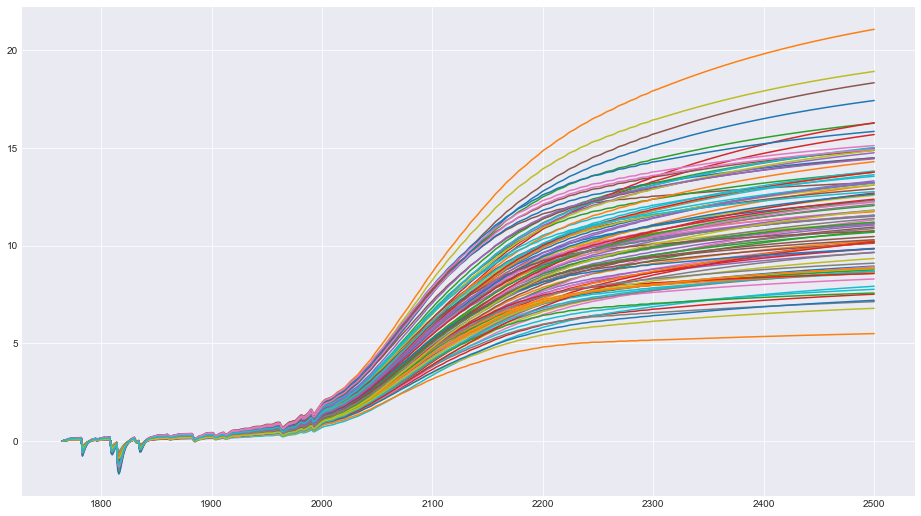

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(rcp85.Emissions.year, T);

### Adding a temperature constraint
The resulting projections show a large spread. Some of these ensemble members are unrealistic, ranging from around 0.4 to 2.0 K temperature change in the present day, whereas we know in reality it is more like 0.95 (plus or minus 0.2). Therefore we can constrain this ensemble to observations.

In [28]:
from fair.tools.constrain import hist_temp

# Cowtan & Way in-filled dataset of global temperatures
CW = np.loadtxt('../fair/tools/tempobs/had4_krig_annual_v2_0_0.csv')
constrained = np.zeros(100, dtype=bool)
for i in range(100):
    # we use observed trend from 1880 to 2016
    constrained[i],_,_,_,_ = hist_temp(
        CW[30:,1], T[1880-1765:2017-1765,i], CW[30:,0])

In [29]:
# How many ensemble members passed the constraint?
print (np.sum(constrained))

31


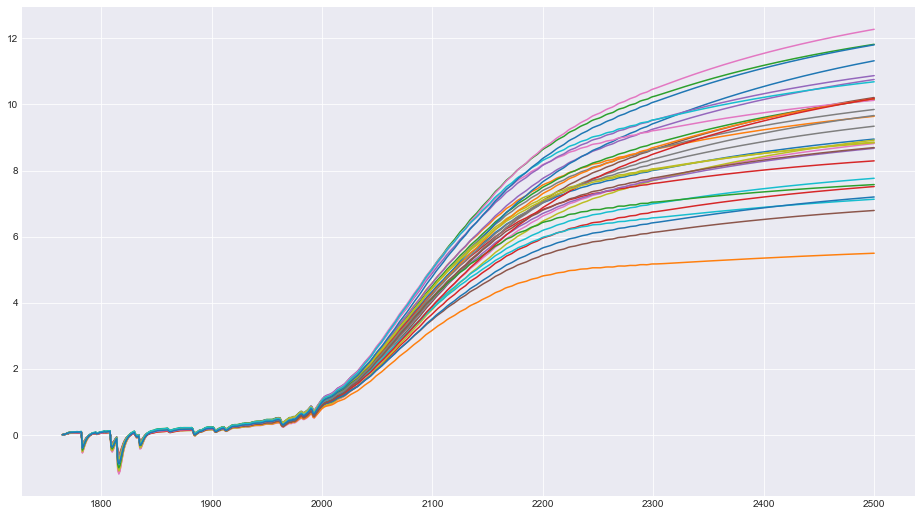

In [30]:
# What does this do to the ensemble?
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(rcp85.Emissions.year, T[:,constrained]);

Some, but not all, of the higher end scenarios have been constrained out, but there is still quite a large range of total temperature change projected for 2500 even under this constraint.

From these constraints it is possible to obtain posterior distributions on effective radiative forcing, ECS, TCR, TCRE and other metrics.

## Restart runs

Sometimes you may want to spin up FaIR in emissions-driven mode, and then impose a constant forcing or other scenario from a certain point in the future. The configuration of FaIR can be saved and re-used. This can be useful for investigating things like the climate change commitment from past emissions, because the carbon cycle and ocean thermal response will not be in their pre-industrial state.

Note the extra tuple element (`restart`) in the call to `fair_scm`. To activate, set the `restart_out = True` keyword in the first run, and `restart_in` keyword in the second run.

Currently, this is only possible when going from a CO2-only run to a CO2-only run, or a multi-forcing run to a CO2-only run. In this example we will run from 1765 to 2020 with all forcing agents, and then investigate the totally hypothetical scenario of a zeroing of CO2 emissions from 2020, with a constant non-CO2 radiative forcing.

In [31]:
# Going from all-forcing to CO2 only. Note natural forcing turned off.
C1, F1, T1, restart = fair_scm(
    emissions   = rcp45.Emissions.emissions[:255,:],
    natural     = fair.ancil.natural.Emissions.emissions[:255,:],
    restart_out = True,
    F_solar     = 0.,
    F_volcanic  = 0.
)

# constant non-CO2 forcing from 2019 to 2500
nonco2_rf = np.sum(F1[-1,1:]) * np.ones(481)

# run forward to 2100 with zero CO2 emissions and constant non-CO2 forcing
C2, F2, T2 = fair_scm(
    emissions   = 0.,
    other_rf    = nonco2_rf,
    useMultigas = False,
    restart_in  = restart
)

# do a normal RCP4.5 run for comparison
C45, F45, T45 = fair_scm(
    emissions  = rcp45.Emissions.emissions,
    F_solar    = 0.,
    F_volcanic = 0.
)

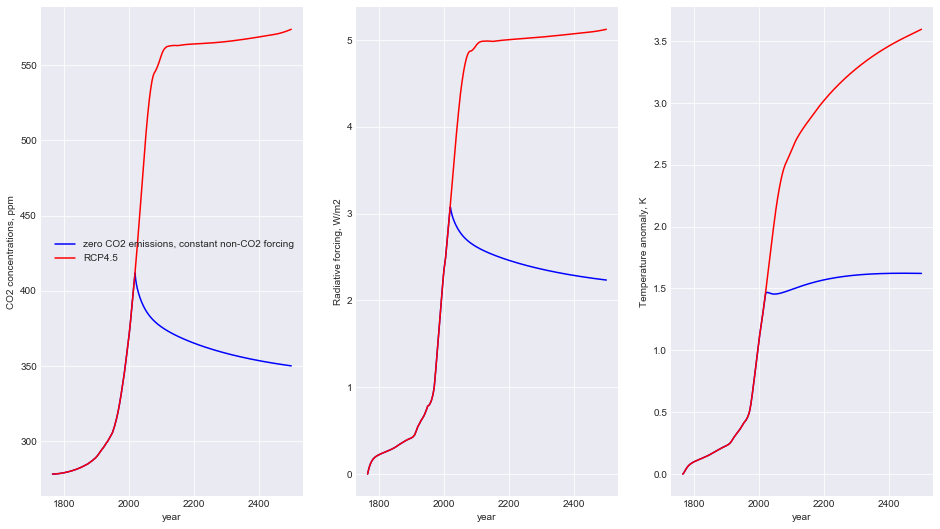

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(rcp45.Emissions.year, np.concatenate((C1[:,0], C2)), color='blue',
         label='zero CO2 emissions, constant non-CO2 forcing')
ax2.plot(rcp45.Emissions.year, np.concatenate((np.sum(F1,axis=1), F2)), color='blue', 
         label='Emissions driven')
ax3.plot(rcp45.Emissions.year, np.concatenate((T1, T2)), color='blue', 
         label='Emissions driven')

ax1.plot(rcp45.Emissions.year, C45[:,0], color='red', label='RCP4.5')
ax2.plot(rcp45.Emissions.year, np.sum(F45,axis=1), color='red', label='RCP4.5')
ax3.plot(rcp45.Emissions.year, T45, color='red', label='RCP4.5')

ax1.set_ylabel('CO2 concentrations, ppm')
ax2.set_ylabel('Radiative forcing, W/m2')
ax3.set_ylabel('Temperature anomaly, K')

ax1.set_xlabel('year')
ax2.set_xlabel('year')
ax3.set_xlabel('year')
ax1.legend();